This notebook is part of Ville Tonteris master's thesis. 

"Underwater sound anomaly detection"

In [42]:
# Import all necessary libraries

import numpy as np
import matplotlib.pyplot as plt
import math
import os
import torch
import torchaudio
import scipy.signal
import pydub
import librosa
import random
from torch.utils.data import Dataset
import pandas as pd
from torch.utils.data import DataLoader
import torchaudio.transforms as transforms
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from IPython.display import Audio
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init
from torch.utils.data import random_split
from torch.distributions.normal import Normal

import tools
import tests
import time





In [2]:
# NOT USED !!!

class SoundDataset(Dataset):
    def __init__(self, annotations_file, audio_dir, transformation, target_sample_rate, num_samples, device):
        self.annotations = pd.read_excel(annotations_file)
        self.audio_dir = audio_dir
        self.transformation = transformation
        self.target_sample_rate = target_sample_rate
        self.num_samples = num_samples
        self.device = device

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        audio_sample_path = self._get_audio_sample_path(index)
        label = self._get_audio_sample_label(index)
        signal, sr = torchaudio.load(audio_sample_path)
        signal = signal.to(self.device)
        signal = self._resample_if_necessary(signal, sr)
        signal = self._mix_down_if_necessary(signal)
        signal = self._cut_if_necessary(signal)
        signal = self._right_pad_if_necessary(signal)
        signal = self.transformation(signal)
        return signal, label

    def _cut_if_necessary(self, signal):
        if signal.shape[1] > self.num_samples:
            signal = signal[:, :self.num_samples]
        return signal

    def _right_pad_if_necessary(self, signal):
        length_signal = signal.shape[1]
        if length_signal < self.num_samples:
            num_missing_samples = self.num_samples - length_signal
            last_dim_padding = (0, num_missing_samples)
            signal = torch.nn.functional.pad(signal, last_dim_padding)
        return signal

    def _resample_if_necessary(self, signal, sr):
        if sr != self.target_sample_rate:
            resampler = torchaudio.transforms.Resample(sr, self.target_sample_rate).to(self.device)
            signal = resampler(signal)
        return signal

    def _mix_down_if_necessary(self, signal):
        if signal.shape[0] > 1:
            signal = torch.mean(signal, dim=0, keepdim=True)
        return signal

    def _get_audio_sample_path(self, index):
        filename = self.annotations.iloc[index]['Filename']
        path = os.path.join(self.audio_dir, filename)
        return path

    def _get_audio_sample_label(self, index):
        return self.annotations.iloc[index]['Type']


In [3]:
# NOT USED !!!

# Define neural network model

class ClassificationModel:
    
    def __init__(self) -> None:
        pass

In [4]:
ANNOTATIONS_FILE = r'C:\shipsEar_AUDIOS\shipsEar.xlsx'
AUDIO_DIR = r'C:\shipsEar_AUDIOS'
#AUDIO_DIR = r'\shipsEar_AUDIOS'
# ANNOTATIONS_FILE = r'C:/Users/elliw/OneDrive/Documents/Aalto/Masters Thesis/shipsEar_AUDIOS/shipsEar.xlsx'
AUDIO_DIR_m = r'C:/shipsEar_AUDIOS'
#  r'C:\Users\elliw\OneDrive\Documents\Aalto\Masters Thesis\shipsEar_AUDIOS'
SAMPLE_RATE = 52734
NUM_SAMPLES = 16000

# Define transformations
transformation = transforms.MelSpectrogram(
    sample_rate=SAMPLE_RATE,
    n_mels=64,
    n_fft=1024,
    hop_length=512
)

# Initialize dataset
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dataset = SoundDataset(ANNOTATIONS_FILE, AUDIO_DIR, transformation, SAMPLE_RATE, NUM_SAMPLES, device)

# Create dataloader
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

model = ClassificationModel()

# Training loop:

# for inputs, targets in dataloader:
#     print(inputs.shape, targets)
#     break




In [5]:
# EXTRACTION OF .WAV METADATA

# Load the .wav file
audio = pydub.AudioSegment.from_wav(r'C:\shipsEar_AUDIOS\16__10_07_13_mscOpera_InicioSalida.wav')

# Extracting basic metadata
print(f"Channels: {audio.channels}")
print(f"Sample width (bytes): {audio.sample_width}")
print(f"Frame rate (sample rate): {audio.frame_rate}")
print(f"Frame width (bytes): {audio.frame_width}")
print(f"Length (ms): {len(audio)}")
print(f"Number of frames: {audio.frame_count()}")
print(f"Sample rate: {audio.frame_rate}")
print(f"Sample width: {audio.sample_width}")
print(f"Max dBFS: {audio.max_dBFS}")
print(f"RMS: {audio.rms}")

Channels: 1
Sample width (bytes): 4
Frame rate (sample rate): 52734
Frame width (bytes): 4
Length (ms): 163226
Number of frames: 8607539.0
Sample rate: 52734
Sample width: 4
Max dBFS: -17.228184102048576
RMS: 8641670


MFCCs shape: (7030, 13)
PCA shape: (7030, 2)
Explained variance ratio: [0.85321164 0.07583919]


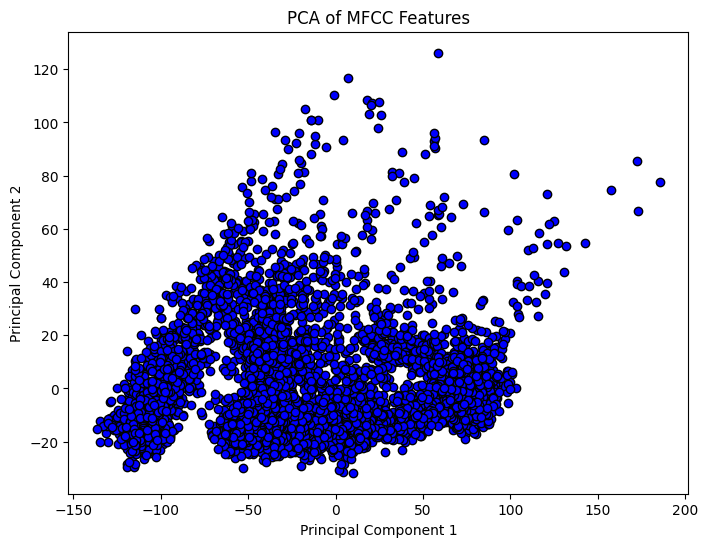

In [6]:
# EXTRACTION OF .WAV PCA AND VISUALIZATION

audio_pca = r'C:\shipsEar_AUDIOS\16__10_07_13_mscOpera_InicioSalida.wav'

y, sr = librosa.load(audio_pca)

# Extract MFCC features
mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)

mfccs = mfccs.T

print(f"MFCCs shape: {mfccs.shape}")

pca = PCA(n_components=2)

mfccs_pca = pca.fit_transform(mfccs)

print(f"PCA shape: {mfccs_pca.shape}")

explained_variance = pca.explained_variance_ratio_
print(f"Explained variance ratio: {explained_variance}")

plt.figure(figsize=(8, 6))
plt.scatter(mfccs_pca[:, 0], mfccs_pca[:, 1], c='blue', edgecolor='k')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of MFCC Features')
plt.show()

c:\Users\elliw\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\elliw\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\elliw\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\elliw\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\

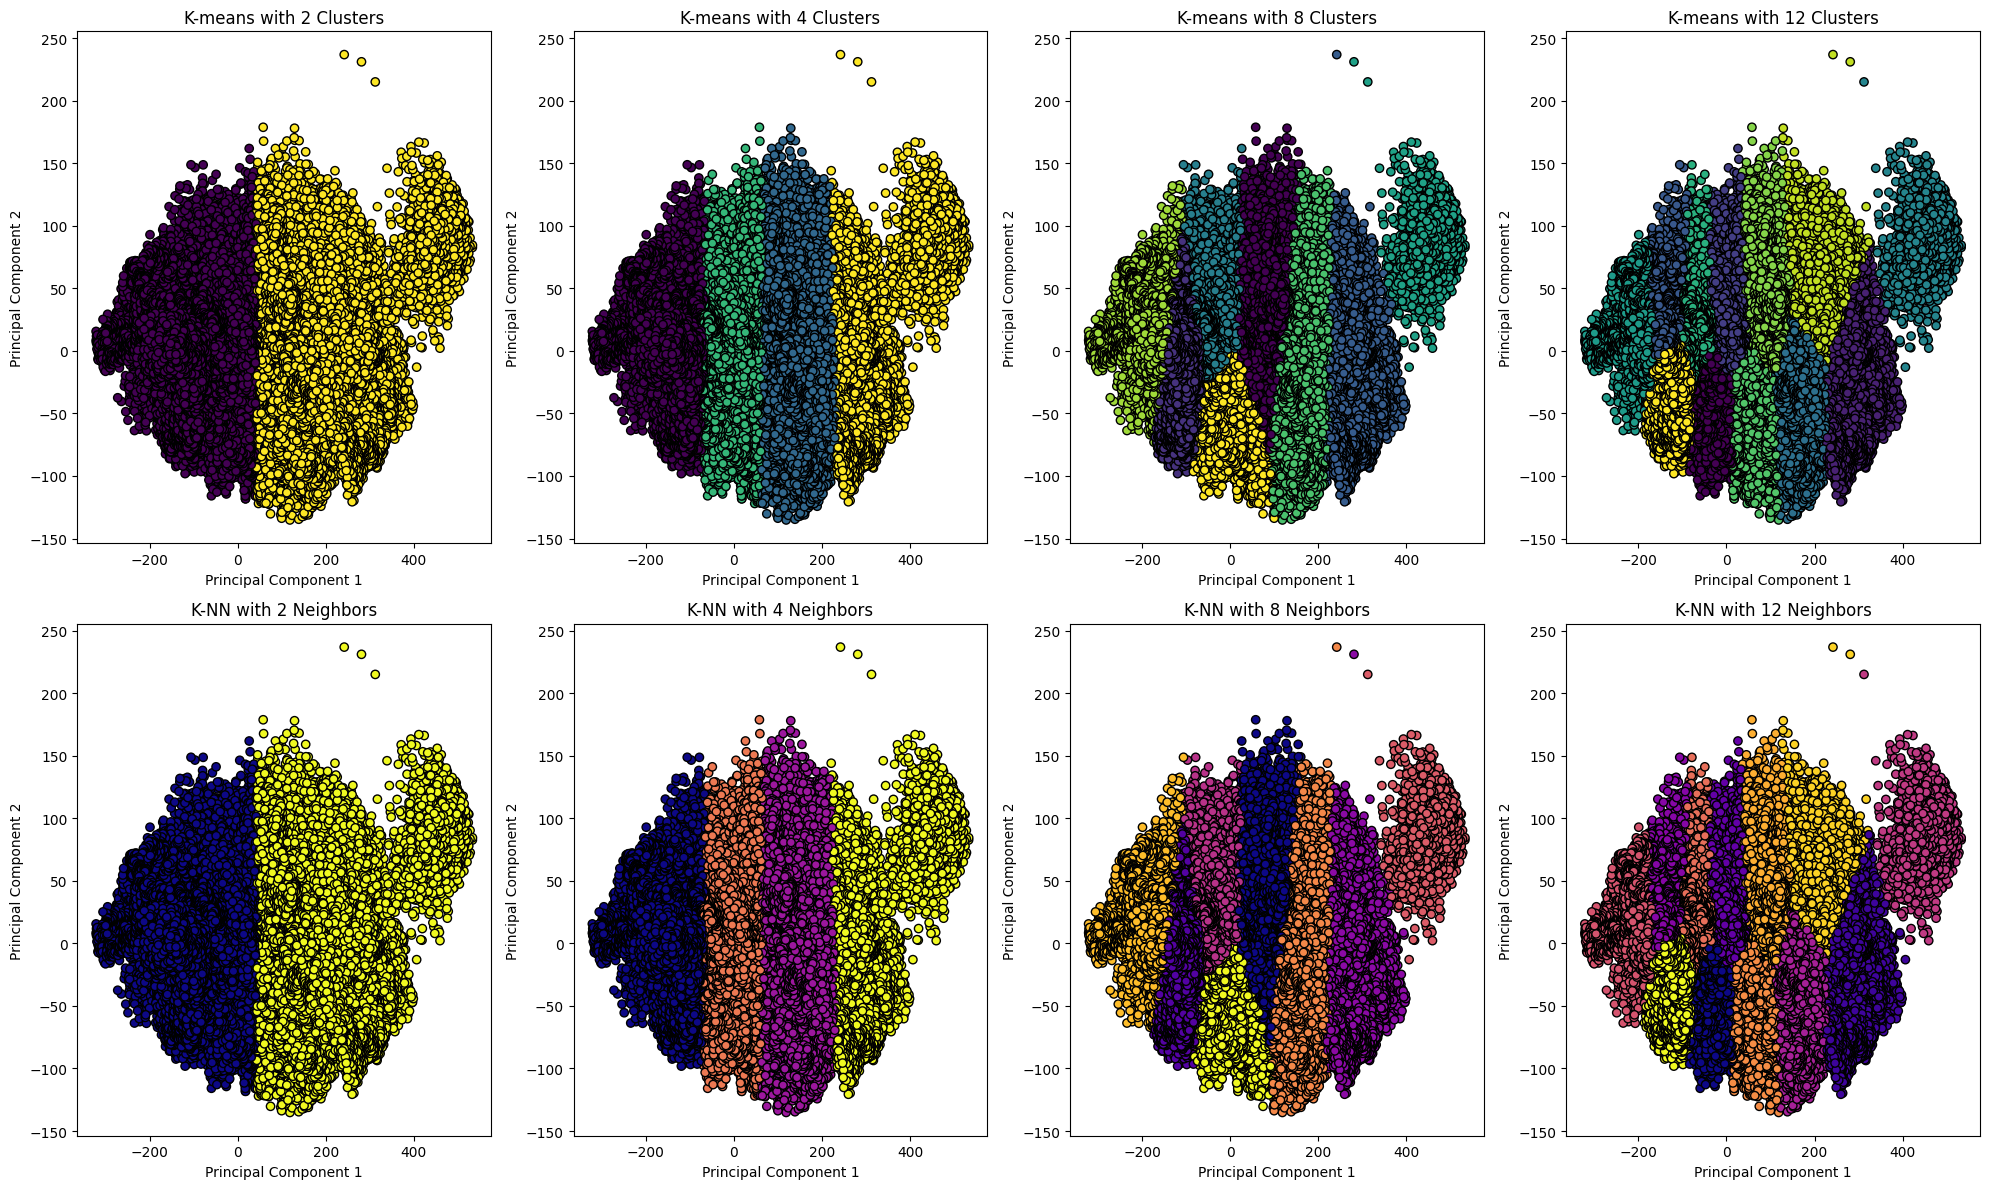

In [7]:
# K-MEANS PREDICTOR

mfccs_list = []
file_names = []

# PCA EXTRACTION

for filename in os.listdir(AUDIO_DIR_m):
    if filename.endswith(".wav"):
        file_path = os.path.join(AUDIO_DIR_m, filename)
        y, sr = librosa.load(file_path)
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=64)
        mfccs_list.append(mfccs.T)
        file_names.append(filename)

mfccs_combined = np.vstack(mfccs_list)
pca_kmeans = PCA(n_components=2)
mfccs_pca_kmeans = pca_kmeans.fit_transform(mfccs_combined)

# KMEANS CLUSTERING

cluster_numbers = [2, 4, 8, 12]
kmeans_models = [KMeans(n_clusters=n).fit(mfccs_pca_kmeans) for n in cluster_numbers]

knn_models = [KNeighborsClassifier(n_neighbors=n).fit(mfccs_pca_kmeans, kmeans.labels_) 
              for kmeans, n in zip(kmeans_models, cluster_numbers)]

# Step 6: Visualize all K-means results in a single figure
fig, axs = plt.subplots(2, 4, figsize=(20, 12))

for i, (ax, kmeans, knn, n_clusters) in enumerate(zip(axs[0], kmeans_models, knn_models, cluster_numbers)):
    ax.scatter(mfccs_pca_kmeans[:, 0], mfccs_pca_kmeans[:, 1], c=kmeans.labels_, cmap='viridis', edgecolor='k')
    ax.set_title(f'K-means with {n_clusters} Clusters')
    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')

    ax_knn = axs[1][i]
    knn_labels = knn.predict(mfccs_pca_kmeans)
    ax_knn.scatter(mfccs_pca_kmeans[:, 0], mfccs_pca_kmeans[:, 1], c=knn_labels, cmap='plasma', edgecolor='k')
    ax_knn.set_title(f'K-NN with {n_clusters} Neighbors')
    ax_knn.set_xlabel('Principal Component 1')
    ax_knn.set_ylabel('Principal Component 2')

plt.tight_layout()
plt.show()


In [8]:
# NEURAL NETWORK CLASSIFIER

# ADAPTED FROM https://medium.com/@mlg.fcu/using-python-to-classify-sounds-a-deep-learning-approach-ef00278bb6ad
# and
# https://towardsdatascience.com/audio-deep-learning-made-simple-sound-classification-step-by-step-cebc936bbe5

metadata_file = ANNOTATIONS_FILE
df = pd.read_excel(metadata_file)
df["relative_path"] = df["Filename"]
#df["relative_path"] = AUDIO_DIR + "\\" + df["Filename"].astype(str)
type_mapping = {type_name: class_id for class_id, type_name in enumerate(df["Type"].unique())}
df["class_id"] = df["Type"].map(type_mapping)
df = df[["relative_path", "class_id"]]

df.head()
print(df["class_id"].min())


0


In [9]:
class AudioUtilization():

    @staticmethod
    def open(audio_file):
        sig, sr = torchaudio.load(audio_file)
        return (sig, sr)
    
    @staticmethod
    def rechannel(audio, new_channel):

        # Convert audio to the desired number of channels
        sig, sr = audio

        if sig.shape[0] == new_channel:
            return audio
        
        if new_channel == 1:
            resig = sig[:1, :]
        
        else:
            resig = torch.cat([sig,sig])

        return ((resig, sr))
    
    @staticmethod
    def pad_trunc(audio, max_ms):
        sig, sr = audio
        num_rows, sig_len = sig.shape
        max_len = sr//1000 * max_ms

        if sig_len > max_len:
            sig = sig[:,:max_len]
        
        elif sig_len < max_len:
            pad_begin_len = random.randint(0, max_len - sig_len)
            pad_end_len = max_len - sig_len - pad_begin_len

            pad_begin = torch.zeros((num_rows,pad_begin_len))
            pad_end = torch.zeros((num_rows,pad_end_len))

            sig = torch.cat((pad_begin, sig, pad_end), 1)

        return (sig, sr)
    
    @staticmethod
    def time_shift(audio, shift_limit):
        sig, sr = audio
        _, sig_len = sig.shape
        shift_amt = int(random.random() * shift_limit * sig_len)
        return (sig.roll(shift_amt), sr)
    
    @staticmethod
    def spectro_gram(audio, n_mels = 64, n_fft = 1024, hop_len = None):
        sig, sr = audio
        top_db = 100

        spec = transforms.MelSpectrogram(sr, n_fft=n_fft, hop_length=hop_len, n_mels=n_mels)(sig)
        
        # Conversion to decibels:
        spec = transforms.AmplitudeToDB(top_db=top_db)(spec)

        return (spec)
    
    @staticmethod
    def spectro_augmen(spec, max_mask_pct = 0.1, n_freq_masks = 1, n_time_masks = 1):
        _, n_mels, n_steps = spec.shape
        mask_value = spec.mean()
        aug_spec = spec

        freq_mask_param = max_mask_pct * n_mels

        for _ in range(n_freq_masks):
            aug_spec = transforms.FrequencyMasking(freq_mask_param)(aug_spec, mask_value)

        time_mask_param = max_mask_pct * n_steps

        for _ in range(n_time_masks):
            aug_spec = transforms.TimeMasking(time_mask_param)(aug_spec, mask_value)

        return aug_spec
    
    @staticmethod
    def pad_spectrogram(spec, max_len):
        n_channels, n_mels, n_steps = spec.shape
        if n_steps < max_len:
            pad_amount = max_len - n_steps
            pad_spec = torch.nn.functional.pad(spec, (0, pad_amount), "constant", 0)
        else:
            pad_spec = spec[:, :, :max_len]
        return pad_spec

In [10]:
class AudioDataset(Dataset):
    def __init__(self, df, data_path):
        self.df = df
        self.data_path = str(data_path)
        self.duration = 4000
        self.sr = 52734
        self.channel = 2
        self.shift_pct = 0.4

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        #audio_file = self.data_path + self.df.loc[idx, "relative_path"]
        #print(f"this is self.path: {self.data_path}")
        #rel_path = self.df.loc[idx, "relative_path"]

        audio_file = os.path.join(self.data_path, self.df.loc[idx, "relative_path"])

        class_id = self.df.loc[idx, "class_id"]


        audio = AudioUtilization.open(audio_file)
        re_channel = AudioUtilization.rechannel(audio, self.channel)
        dur_audio = AudioUtilization.pad_trunc(re_channel, self.duration)
        shift_audio = AudioUtilization.time_shift(dur_audio, self.shift_pct)
        spectrogram = AudioUtilization.spectro_gram(shift_audio, n_mels=64, n_fft=1024, hop_len=None)
        aug_spectrogram = AudioUtilization.spectro_augmen(spectrogram, max_mask_pct=0.1, n_freq_masks=2, n_time_masks=2)

        return aug_spectrogram, class_id

In [11]:
class AudioDataset_longer(Dataset):
    def __init__(self, df, data_path):
        self.df = df
        self.data_path = str(data_path)
        self.duration = 10000
        self.sr = 52734
        self.channel = 2
        self.shift_pct = 0.4

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        #audio_file = self.data_path + self.df.loc[idx, "relative_path"]
        #print(f"this is self.path: {self.data_path}")
        #rel_path = self.df.loc[idx, "relative_path"]

        audio_file = os.path.join(self.data_path, self.df.loc[idx, "relative_path"])

        class_id = self.df.loc[idx, "class_id"]


        audio = AudioUtilization.open(audio_file)
        re_channel = AudioUtilization.rechannel(audio, self.channel)
        dur_audio = AudioUtilization.pad_trunc(re_channel, self.duration)
        shift_audio = AudioUtilization.time_shift(dur_audio, self.shift_pct)
        spectrogram = AudioUtilization.spectro_gram(shift_audio, n_mels=64, n_fft=1024, hop_len=None)
        aug_spectrogram = AudioUtilization.spectro_augmen(spectrogram, max_mask_pct=0.1, n_freq_masks=2, n_time_masks=2)

        return aug_spectrogram, class_id

In [12]:
# Neural network classifier

class AudioClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        conv_layers = []

        # First Convolution Block with Relu and Batch Norm. Use Kaiming Initialization
        self.conv1 = nn.Conv2d(2, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
        self.relu1 = nn.ReLU()
        self.bn1 = nn.BatchNorm2d(8)
        init.kaiming_normal_(self.conv1.weight, a=0.1)
        self.conv1.bias.data.zero_()
        conv_layers += [self.conv1, self.relu1, self.bn1]

        # Second Convolution Block
        self.conv2 = nn.Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu2 = nn.ReLU()
        self.bn2 = nn.BatchNorm2d(16)
        init.kaiming_normal_(self.conv2.weight, a=0.1)
        self.conv2.bias.data.zero_()
        conv_layers += [self.conv2, self.relu2, self.bn2]

        # Second Convolution Block
        self.conv3 = nn.Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu3 = nn.ReLU()
        self.bn3 = nn.BatchNorm2d(32)
        init.kaiming_normal_(self.conv3.weight, a=0.1)
        self.conv3.bias.data.zero_()
        conv_layers += [self.conv3, self.relu3, self.bn3]

        # Second Convolution Block
        self.conv4 = nn.Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu4 = nn.ReLU()
        self.bn4 = nn.BatchNorm2d(64)
        init.kaiming_normal_(self.conv4.weight, a=0.1)
        self.conv4.bias.data.zero_()
        conv_layers += [self.conv4, self.relu4, self.bn4]

        # Linear Classifier
        self.ap = nn.AdaptiveAvgPool2d(output_size=1)
        self.lin = nn.Linear(in_features=64, out_features=13)

        # Wrap the Convolutional Blocks
        self.conv = nn.Sequential(*conv_layers)
    def forward(self, x):
        # Run the convolutional blocks
        x = self.conv(x)
        # print(x.shape)

        # Adaptive pool and flatten for input to linear layer
        x = self.ap(x)
        x = x.view(x.shape[0], -1)
        # print(x.shape)

        # Linear layer
        x = self.lin(x)
        # print(x.shape)

        # Final output
        return x
    
    def custom_collate_fn(batch):
        max_len = max([item[0].shape[2] for item in batch])
        specs = [AudioUtilization.pad_spectrogram(item[0], max_len) for item in batch]
        labels = torch.tensor([item[1] for item in batch])
        return torch.stack(specs), labels

# Create the model and put it on the GPU if available
nnModel = AudioClassifier()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
nnModel = nnModel.to(device)
# Check that it is on Cuda
next(nnModel.parameters()).device


device(type='cpu')

In [13]:
# Implementing dataloader for shorter spectrograms (4 s)

data_path = r"C:\shipsEar_AUDIOS"

myds = AudioDataset(df, data_path)

torch.manual_seed(42)

# Random split of 80:20 between training and validation
num_items = len(myds)
num_train = round(num_items * 0.8)
num_val = num_items - num_train
train_ds, val_ds = random_split(myds, [num_train, num_val])

# Create training and validation data loaders
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=16, shuffle=True, collate_fn=AudioClassifier.custom_collate_fn)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size=16, shuffle=False, collate_fn=AudioClassifier.custom_collate_fn)

In [14]:
# Implementing dataloader for longer spectrograms (10 s)

data_path = r"C:\shipsEar_AUDIOS"

myds = AudioDataset_longer(df, data_path)

# Random split of 80:20 between training and validation
num_items = len(myds)
num_train = round(num_items * 0.8)
num_val = num_items - num_train
train_ds_long, val_ds_long = random_split(myds, [num_train, num_val])

# Create training and validation data loaders
train_dl_long = torch.utils.data.DataLoader(train_ds_long, batch_size=16, shuffle=True, collate_fn=AudioClassifier.custom_collate_fn)
val_dl_long = torch.utils.data.DataLoader(val_ds_long, batch_size=16, shuffle=False, collate_fn=AudioClassifier.custom_collate_fn)

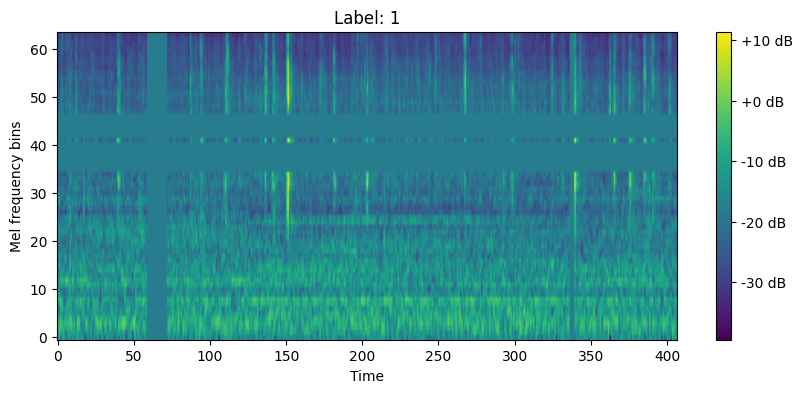

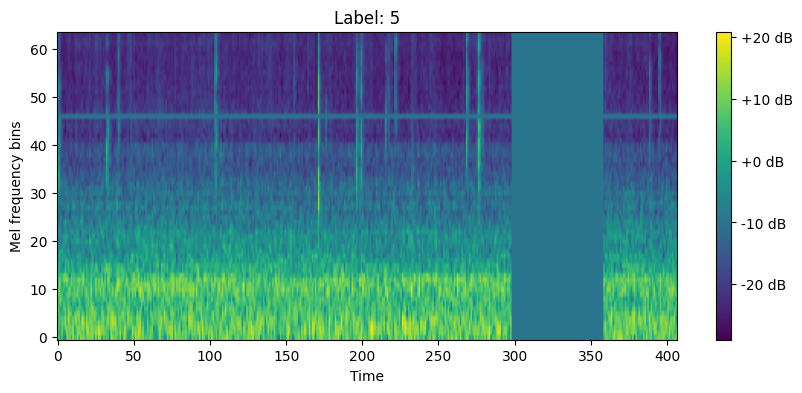

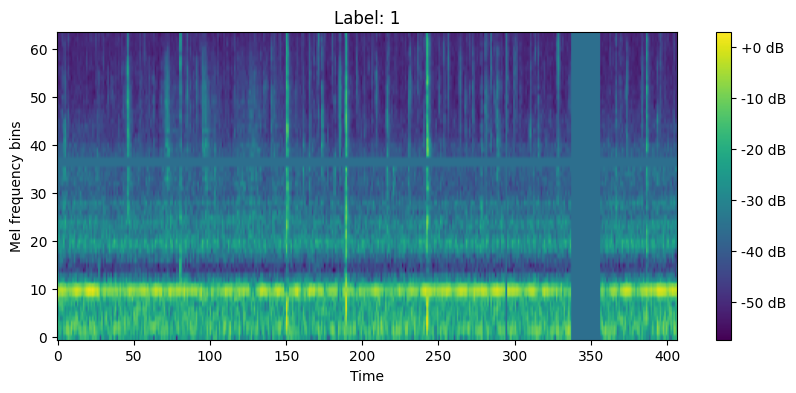

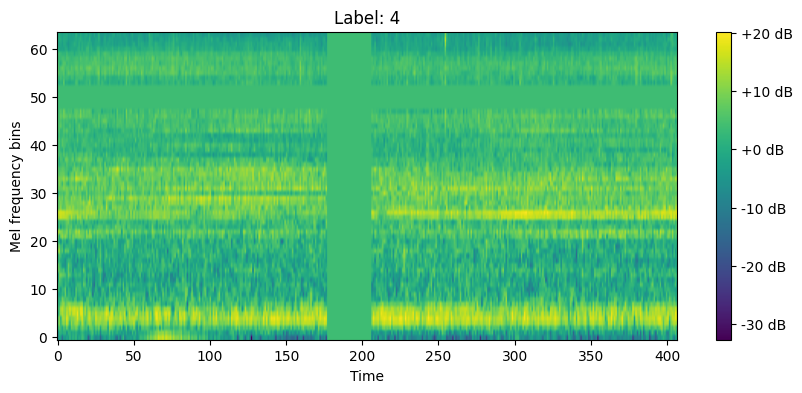

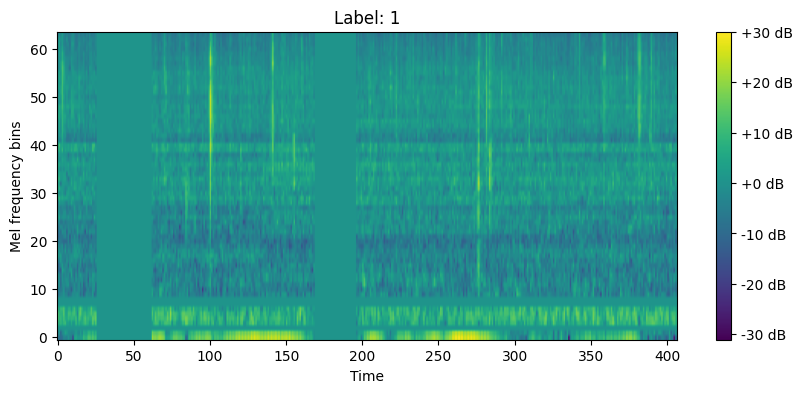

In [15]:
# Plot few spectrograms 

def plot_spectrogram(spectrogram, title=None):
    # Convert spectrogram from tensor to numpy for plotting
    spectrogram = spectrogram.cpu().numpy()
    
    # Assuming the spectrogram is in the shape [channels, n_mels, time], we can plot the first channel
    plt.figure(figsize=(10, 4))
    plt.imshow(spectrogram[0], aspect='auto', origin='lower')
    plt.colorbar(format='%+2.0f dB')
    if title:
        plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Mel frequency bins')
    plt.show()

# Get a batch of data
for i, data in enumerate(train_dl):
    inputs, labels = data[0], data[1]
    
    # Visualize the first few spectrograms
    for j in range(min(5, inputs.shape[0])):
        plot_spectrogram(inputs[j], title=f"Label: {labels[j].item()}")
    
    # Only plot the first batch
    break

In [16]:
# Classical Neural Network training loop

def nn_training(model, train_dl, num_epochs, lr):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr = lr)
    model.train()

    for epoch in range(num_epochs):
        running_loss = 0.0
        correct_pred = 0
        total_pred = 0

        for i, data in enumerate(train_dl):

            inputs, labels = data[0].to(device), data[1].to(device)

            inputs_m, inputs_s = inputs.mean(), inputs.std()
            inputs = (inputs - inputs_m) / inputs_s

            optimizer.zero_grad()

            outputs = model(inputs)
            # print(f"outputs: {outputs.shape}")
            # print(f"labels: {labels.shape}")
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            _, pred = torch.max(outputs, 1)

            correct_pred += (pred == labels).sum().item()
            total_pred += pred.shape[0]
        
        num_batches = len(train_dl)
        avg_loss = running_loss / num_batches
        acc = correct_pred/total_pred
        
        print(f"Epoch: {epoch}, Loss: {avg_loss:.2f}, Accuracy: {acc:.2f}")
    
    print("Finished training")




In [17]:
# Training with shorter spectrograms (4 s)

learning_rate = 0.001
num_epochs = 60
nn_training(nnModel, train_dl, num_epochs, learning_rate)

Epoch: 0, Loss: 2.55, Accuracy: 0.17
Epoch: 1, Loss: 2.49, Accuracy: 0.24
Epoch: 2, Loss: 2.36, Accuracy: 0.24
Epoch: 3, Loss: 2.30, Accuracy: 0.33
Epoch: 4, Loss: 2.21, Accuracy: 0.35
Epoch: 5, Loss: 2.13, Accuracy: 0.32
Epoch: 6, Loss: 2.12, Accuracy: 0.35
Epoch: 7, Loss: 2.09, Accuracy: 0.35
Epoch: 8, Loss: 2.09, Accuracy: 0.36
Epoch: 9, Loss: 2.06, Accuracy: 0.46
Epoch: 10, Loss: 1.97, Accuracy: 0.42
Epoch: 11, Loss: 1.97, Accuracy: 0.43
Epoch: 12, Loss: 1.86, Accuracy: 0.49
Epoch: 13, Loss: 1.93, Accuracy: 0.43
Epoch: 14, Loss: 1.83, Accuracy: 0.50
Epoch: 15, Loss: 1.79, Accuracy: 0.49
Epoch: 16, Loss: 1.87, Accuracy: 0.46
Epoch: 17, Loss: 1.80, Accuracy: 0.44
Epoch: 18, Loss: 1.66, Accuracy: 0.51
Epoch: 19, Loss: 1.72, Accuracy: 0.46
Epoch: 20, Loss: 1.55, Accuracy: 0.58
Epoch: 21, Loss: 1.63, Accuracy: 0.51
Epoch: 22, Loss: 1.59, Accuracy: 0.51
Epoch: 23, Loss: 1.41, Accuracy: 0.57
Epoch: 24, Loss: 1.48, Accuracy: 0.60
Epoch: 25, Loss: 1.47, Accuracy: 0.60
Epoch: 26, Loss: 1.43,

In [18]:
# Training with longer spectrograms (10 s)
nnModel_longer = AudioClassifier()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
nnModel_longer = nnModel_longer.to(device)

nn_training(nnModel_longer, train_dl_long, num_epochs, learning_rate)

Epoch: 0, Loss: 2.53, Accuracy: 0.21
Epoch: 1, Loss: 2.37, Accuracy: 0.31
Epoch: 2, Loss: 2.23, Accuracy: 0.35
Epoch: 3, Loss: 2.16, Accuracy: 0.32
Epoch: 4, Loss: 2.26, Accuracy: 0.33
Epoch: 5, Loss: 2.15, Accuracy: 0.39
Epoch: 6, Loss: 2.08, Accuracy: 0.33
Epoch: 7, Loss: 2.00, Accuracy: 0.35
Epoch: 8, Loss: 1.98, Accuracy: 0.42
Epoch: 9, Loss: 1.92, Accuracy: 0.43
Epoch: 10, Loss: 1.89, Accuracy: 0.46
Epoch: 11, Loss: 1.84, Accuracy: 0.50
Epoch: 12, Loss: 1.88, Accuracy: 0.47
Epoch: 13, Loss: 1.80, Accuracy: 0.58
Epoch: 14, Loss: 1.74, Accuracy: 0.54
Epoch: 15, Loss: 1.82, Accuracy: 0.50
Epoch: 16, Loss: 1.71, Accuracy: 0.54
Epoch: 17, Loss: 1.68, Accuracy: 0.51
Epoch: 18, Loss: 1.66, Accuracy: 0.57
Epoch: 19, Loss: 1.67, Accuracy: 0.57
Epoch: 20, Loss: 1.62, Accuracy: 0.56
Epoch: 21, Loss: 1.54, Accuracy: 0.58
Epoch: 22, Loss: 1.49, Accuracy: 0.56
Epoch: 23, Loss: 1.51, Accuracy: 0.58
Epoch: 24, Loss: 1.47, Accuracy: 0.56
Epoch: 25, Loss: 1.40, Accuracy: 0.64
Epoch: 26, Loss: 1.36,

In [29]:
# Autoencoders encoder class
# Short samples (4s)


class AE_Encoder(nn.Module):

    def __init__(self) -> None:
        super(AE_Encoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(2*64*407, 500),
            nn.ReLU(),
            nn.Linear(500, 250),
            nn.ReLU(),
            nn.Linear(250, 13),
            nn.ReLU()
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        z = self.encoder(x)
        z = z.squeeze(1)
        return z

In [30]:
# Autoencoders decoder class
# Short samples (4s)

class AE_Decoder(nn.Module):
    def __init__(self) -> None:
        super(AE_Decoder, self).__init__()

        self.decoder = nn.Sequential(
            nn.Linear(13, 250),
            nn.ReLU(),
            nn.Linear(250, 500),
            nn.ReLU(),
            nn.Linear(500, 2*64*407)
        )

    def forward(self, z):
        x = self.decoder(z)
        x_hat = x.view(-1, 2, 64, 407)
        return x_hat


In [31]:
ae_encoder = AE_Encoder()
ae_decoder = AE_Decoder()

In [38]:
# Autoencoders encoder class
# Long samples (10 s)

class AE_Encoder_long(nn.Module):

    def __init__(self) -> None:
        super(AE_Encoder_long, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(2*64*1016, 500),
            nn.ReLU(),
            nn.Linear(500, 250),
            nn.ReLU(),
            nn.Linear(250, 13),
            nn.ReLU()
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        z = self.encoder(x)
        z = z.squeeze(1)
        return z

In [39]:
# Autoencoders decoder class
# Long samples (10 s)

class AE_Decoder_long(nn.Module):
    def __init__(self) -> None:
        super(AE_Decoder_long, self).__init__()

        self.decoder = nn.Sequential(
            nn.Linear(13, 250),
            nn.ReLU(),
            nn.Linear(250, 500),
            nn.ReLU(),
            nn.Linear(500, 2*64*1016)
        )

    def forward(self, z):
        x = self.decoder(z)
        x_hat = x.view(-1, 2, 64, 1016)
        return x_hat


In [40]:
ae_encoder_long = AE_Encoder_long()
ae_decoder_long = AE_Decoder_long()

In [24]:
for i in train_dl:
    print(i[0].shape)
    print(i[1].shape)
    break

for i in train_dl_long:
    print(i[0].shape)
    print(i[1].shape)
    break

torch.Size([16, 2, 64, 407])
torch.Size([16])
torch.Size([16, 2, 64, 1016])
torch.Size([16])


In [41]:
# Autoencoder Training loop
def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

def train_epoch(trainloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion):
    encoder.train()
    decoder.train()
    total_loss = 0

    for image in trainloader:
        #print(image.size)
        #image[0] = image[0].to(device)
        #images = image[0].view(image[0].size(0), -1)
        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()
        encoded = encoder.forward(image[0])
        #print(f"encoded shape: {encoded.shape}")
        decoded = decoder.forward(encoded)

        loss = criterion(decoded, image[0])

        loss.backward()

        encoder_optimizer.step()
        decoder_optimizer.step()

        total_loss += loss.item()

    return total_loss / len(trainloader)


start = time.time()
learning_rate = 0.001
encoder_optimizer_long = torch.optim.Adam(ae_encoder_long.parameters(), lr=learning_rate)
decoder_optimizer_long = torch.optim.Adam(ae_decoder_long.parameters(), lr=learning_rate)
n_epochs = 30
criterion_long = nn.MSELoss()
plot_losses = []
plot_loss_total = 0
print_loss_total = 0
print_every= 1
plot_every= 1
ae_encoder_long.to(device)
ae_decoder_long.to(device)

for state in encoder_optimizer_long.state.values():
    for k, v in state.items():
        if isinstance(v, torch.Tensor):
            state[k] = v.to(device)

for state in decoder_optimizer_long.state.values():
    for k, v in state.items():
        if isinstance(v, torch.Tensor):
            state[k] = v.to(device)

for epoch in range(1, n_epochs+1):
    loss = train_epoch(train_dl_long, ae_encoder_long, ae_decoder_long, encoder_optimizer_long, decoder_optimizer_long, criterion_long)
    print_loss_total += loss
    plot_loss_total += loss

    if epoch % print_every == 0:
        print_loss_avg = print_loss_total / print_every
        print_loss_total = 0
        print('%s (%d %d%%) %.4f' % (timeSince(start, epoch / n_epochs),
                                    epoch, epoch / n_epochs * 100, print_loss_avg))

    if epoch % plot_every == 0:
        plot_loss_avg = plot_loss_total / plot_every
        plot_losses.append(plot_loss_avg)
        plot_loss_total = 0



0m 10s (- 4m 50s) (1 3%) 472.0497
0m 19s (- 4m 32s) (2 6%) 324.0003
0m 28s (- 4m 16s) (3 10%) 157.0075
0m 37s (- 4m 4s) (4 13%) 97.0824
0m 46s (- 3m 53s) (5 16%) 75.0700
0m 55s (- 3m 42s) (6 20%) 69.5759
1m 5s (- 3m 34s) (7 23%) 61.8574
1m 14s (- 3m 25s) (8 26%) 60.3387
1m 23s (- 3m 15s) (9 30%) 55.8139
1m 32s (- 3m 5s) (10 33%) 55.6186
1m 42s (- 2m 56s) (11 36%) 51.9152
1m 51s (- 2m 46s) (12 40%) 63.2490
2m 0s (- 2m 37s) (13 43%) 67.9605
2m 9s (- 2m 27s) (14 46%) 82.0662
2m 18s (- 2m 18s) (15 50%) 69.3902
2m 27s (- 2m 9s) (16 53%) 56.1743
2m 36s (- 1m 59s) (17 56%) 56.1065
2m 45s (- 1m 50s) (18 60%) 65.0610
2m 55s (- 1m 41s) (19 63%) 57.6424
3m 4s (- 1m 32s) (20 66%) 51.6112
3m 13s (- 1m 22s) (21 70%) 51.6306
3m 22s (- 1m 13s) (22 73%) 49.4756
3m 31s (- 1m 4s) (23 76%) 49.0597
3m 40s (- 0m 55s) (24 80%) 49.1491
3m 49s (- 0m 45s) (25 83%) 50.2591
3m 58s (- 0m 36s) (26 86%) 48.8888
4m 7s (- 0m 27s) (27 90%) 49.3564
4m 17s (- 0m 18s) (28 93%) 47.5195
4m 26s (- 0m 9s) (29 96%) 49.4570
4m 

In [24]:
tools.save_model(ae_encoder, '1_ae_encoder.pth', confirm=True)
tools.save_model(ae_decoder, '1_ae_decoder.pth', confirm=True)

Model saved to 1_ae_encoder.pth.
Model saved to 1_ae_decoder.pth.


Use t-SNE
Use Spectral Embedding


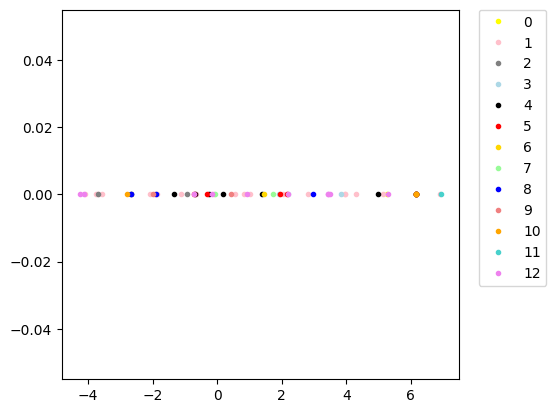

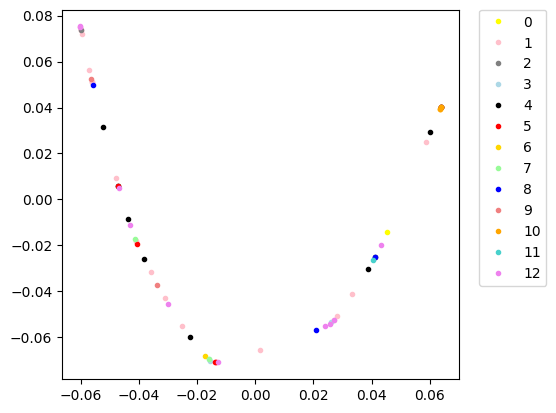

In [27]:
# Visualize embeddings

tests.visualize_embeddings(ae_encoder, train_dl, n_samples=1000, device=device, algo="tsne")

tests.visualize_embeddings(ae_encoder, train_dl, n_samples=1000, device=device, algo="spectral")

In [28]:
start = time.time()
ae_encoder_long = AE_Encoder()
ae_decoder_long = AE_Decoder()
ae_encoder_long.to(device)
ae_decoder_long.to(device)

learning_rate = 0.001
encoder_optimizer_long = torch.optim.Adam(ae_encoder_long.parameters(), lr=learning_rate)
decoder_optimizer_long = torch.optim.Adam(ae_decoder_long.parameters(), lr=learning_rate)
n_epochs = 30
criterion_long = nn.MSELoss()
plot_losses = []
plot_loss_total = 0
print_loss_total = 0
print_every= 1
plot_every= 1



for state in encoder_optimizer_long.state.values():
    for k, v in state.items():
        if isinstance(v, torch.Tensor):
            state[k] = v.to(device)

for state in decoder_optimizer_long.state.values():
    for k, v in state.items():
        if isinstance(v, torch.Tensor):
            state[k] = v.to(device)

for epoch in range(1, n_epochs+1):
    loss = train_epoch(train_dl_long, ae_encoder_long, ae_decoder_long, encoder_optimizer_long, decoder_optimizer_long, criterion_long)
    print_loss_total += loss
    plot_loss_total += loss

    if epoch % print_every == 0:
        print_loss_avg = print_loss_total / print_every
        print_loss_total = 0
        print('%s (%d %d%%) %.4f' % (timeSince(start, epoch / n_epochs),
                                    epoch, epoch / n_epochs * 100, print_loss_avg))

    if epoch % plot_every == 0:
        plot_loss_avg = plot_loss_total / plot_every
        plot_losses.append(plot_loss_avg)
        plot_loss_total = 0


RuntimeError: mat1 and mat2 shapes cannot be multiplied (16x130048 and 52096x500)

In [ ]:
# Visualize embeddings

tests.visualize_embeddings(ae_encoder_long, train_dl_long, n_samples=1000, device=device)

In [ ]:
# UNet-architecture AutoEncoder

class Unet()

SyntaxError: invalid syntax (2718291594.py, line 3)

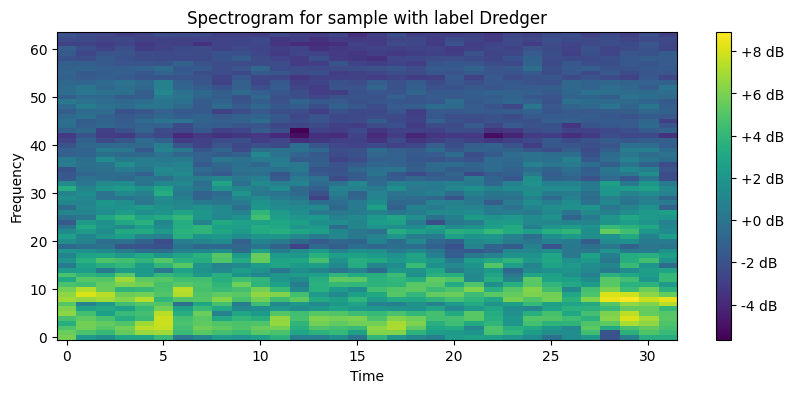

In [ ]:
def visualize_spectrogram(spectrogram, title="Spectrogram"):
    plt.figure(figsize=(10, 4))
    plt.title(title)
    plt.imshow(spectrogram.log2().numpy(), cmap='viridis', aspect='auto', origin='lower')
    plt.colorbar(format='%+2.0f dB')
    plt.xlabel("Time")
    plt.ylabel("Frequency")
    plt.show()

signal, label = dataset[0]  # Get the first sample

# Visualize the spectrogram
visualize_spectrogram(signal[0], title=f"Spectrogram for sample with label {label}")

c:\Users\elliw\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\signal\_spectral_py.py:2017: UserWarning: nperseg = 256 is greater than input length  = 32, using nperseg = 32
  warnings.warn('nperseg = {0:d} is greater than input length '


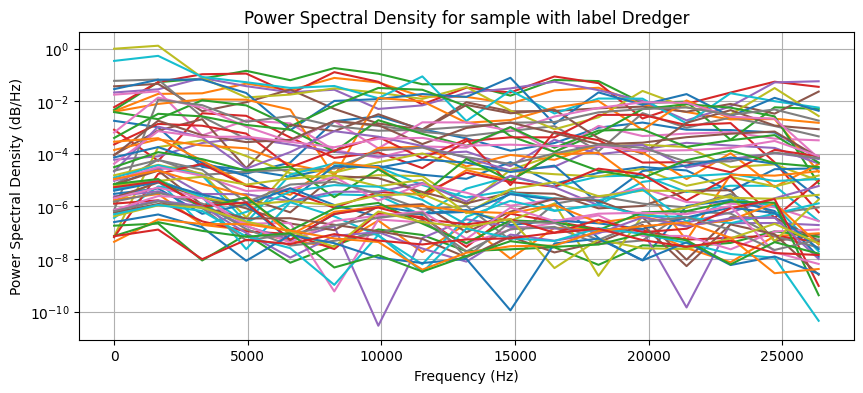

In [ ]:
# Function to compute the power spectral density

def show_psd(signal, sample_rate, label):

    signal = signal.numpy()

    freqs, psd = scipy.signal.welch(signal, sample_rate)

    # Plot the PSD
    plt.figure(figsize=(10, 4))
    plt.semilogy(freqs, psd.T)
    plt.title(f"Power Spectral Density for sample with label {label}")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Power Spectral Density (dB/Hz)")
    plt.grid()
    plt.show()

# Load a single sample from the dataset
dataset = SoundDataset(ANNOTATIONS_FILE, AUDIO_DIR, transformation, SAMPLE_RATE, NUM_SAMPLES, device)
signal, label = dataset[0]  # Get the first sample

# Reshape signal for PSD computation
signal = signal.squeeze()  # Remove single-dimensional entries from the shape of the tensor

# Compute and save the PSD plot
show_psd(signal, SAMPLE_RATE, label)
